#### `Decision Tree Classification`
##### `Target: Species`

Duplicates Found: 1
Removing Duplicates...
Removed Duplicates...
Train Model Score: 0.6666666666666666
Test Model Score: 0.68
Best DTC Train Model Score: 0.9393939393939394
Best DTC Test Model Score: 1.0
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       1.00      1.00      1.00        15
   virginica       1.00      1.00      1.00        16

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



,sepal_length,sepal_width,petal_length,petal_width,Species_Predicted,setosa,versicolor,virginica
0,5.5,2.5,4.0,1.3,versicolor,0.0,1.0,0.0
1,6.9,3.1,5.1,2.3,virginica,0.0,0.0,1.0
2,5.1,2.5,3.0,1.1,versicolor,0.0,1.0,0.0


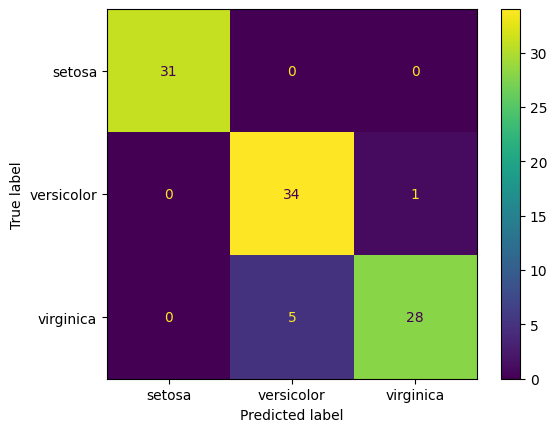

In [ ]:
from warnings import filterwarnings
filterwarnings("ignore")

#----------------------
#Step-1: Data Ingestion
#----------------------

import pandas as pd
df = pd.read_csv("iris.csv")
df.head(1)

#----------------------------------------
#Step-2: Data Sanity - Duplicate removals
#----------------------------------------

duplicate_count = df.duplicated().sum()

if duplicate_count > 0:
    print(f'Duplicates Found: {duplicate_count}')
    print('Removing Duplicates...')
    df = df.drop_duplicates(keep = "first").reset_index(drop = True)
    print('Removed Duplicates...')
    df.shape
else:
    print('No Duplicates Found')

#------------------------
#Step-3: Separate X and Y
#------------------------

X = df.drop(columns = ["species"])
Y = df["species"]

#-----------------------------------
#Step-4: Remove High Unique Cat Cols
#-----------------------------------

card = df.select_dtypes(include = "object").nunique() / len(df)
high_card = card[card >= 0.9]
X = X.drop(columns = high_card.index)

#------------------------
#Step-5: Train Test Split
#------------------------

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.33, random_state=42)

#--------------------------------
#Step-6: Apply Preprocessing on X
#--------------------------------

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
).set_output(transform= "pandas")

num_pipe.fit(xtrain)

xtrain_pre = num_pipe.transform(xtrain)
xtest_pre = num_pipe.transform(xtest)

#---------------------------------
#Step-7: Build Model: DecisionTree
#---------------------------------

from sklearn.tree import DecisionTreeClassifier
dtc_model = DecisionTreeClassifier(
    max_depth = 1,
    min_samples_split = 5,
    min_samples_leaf = 5,
    random_state=42
)

dtc_model.fit(xtrain_pre, ytrain)
print(f'Train Model Score: {dtc_model.score(xtrain_pre, ytrain)}')
print(f'Test Model Score: {dtc_model.score(xtest_pre, ytest)}')

#-----------------------------
#Step-8: Hyperparameter Tuning
#-----------------------------

from sklearn.model_selection import GridSearchCV
params = {"max_depth": [2,3,4,5], "min_samples_split": [5,6,7,8], "min_samples_leaf": [5,6,7,8]}

base_dtc = DecisionTreeClassifier(random_state=42)
gscv = GridSearchCV(base_dtc, params, cv=5, scoring="f1_macro")
gscv.fit(xtrain_pre, ytrain)

best_dtc = gscv.best_estimator_
print(f'Best DTC Train Model Score: {best_dtc.score(xtrain_pre, ytrain)}')
print(f'Best DTC Test Model Score: {best_dtc.score(xtest_pre, ytest)}')

#----------------------
#Step-9: Evaluate Model
#----------------------

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_dtc, xtrain_pre, ytrain)

from sklearn.metrics import classification_report
ypred_pre = best_dtc.predict(xtest_pre)
print(classification_report(ytest, ypred_pre))

best_dtc.feature_importances_

#---------------------------------------------------
#Step-10: Model Inference (Out of Sample Prediction)
#---------------------------------------------------

xnew = pd.read_csv('iris_sample.csv')
xnew_pre = num_pipe.transform(xnew) 

ynew_predict = best_dtc.predict(xnew_pre)
ynew_proba = best_dtc.predict_proba(xnew_pre)

xnew['Species_Predicted'] = ynew_predict
xnew[best_dtc.classes_] = ynew_proba
xnew.head(3)